# Model Evaluation

This notebook benchmarks all three models (literal, pragmatic, and neural network) on the human-human data, producing the tables and results in $\textbf{Section 6: Results and Analysis}$.

In [1]:
# Set notebook up to load files from Science repo
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

RANDOM_SEED = 42
import random
random.seed(RANDOM_SEED)

In [3]:
import numpy as np
import pandas as pd
import pickle
import json
import copy

import matplotlib.pylab as plt
import seaborn as sns

In [4]:
import scipy

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

# Test Configuration

Load data, set up file structure, etc.

In [5]:
TEST_FOLDER_PATH = "data/benchmarks_test/"

CV_FOLD_DATA = json.load(open("data/model_training_10fold/test_train_splits.json"))

In [6]:
from science.analysis.model_benchmarking import human_human_experiment_dataframe, offline_benchmark_levels, run_models_on_human_human_data 
from science.analysis.model_benchmarking import all_offline_benchmark_permutations, eval_model_against_test_levels, get_all_reward_configs

# Load benchmark and reward configurations
benchmark_levels_by_config_key = all_offline_benchmark_permutations()
reward_config_list = get_all_reward_configs()

# Get actual gameplay records from experiment
human_experiment_games = human_human_experiment_dataframe()

## Configure Models

In [7]:
from science.agents.agents import MultivariateNormalLearner, ExpPseudoPragmatic, StatefulFeedforwardNeuralAgent
from science.observations.text_analysis import vader_observation

literal = MultivariateNormalLearner(name="Literal", valence_func=vader_observation, precision_scale=2)
pragmatic = MultivariateNormalLearner(name="Pragmatic", precision_scale=2, pragmatic_precision=2, pragmatic_valence=-30)

basic_models = [literal, pragmatic]

print(["{}, ".format(c) for c in basic_models])

['Literal (V30,P2), ', 'Pragmatic (V30,P2)(PragV-30, PragP2), ']


## Configure Basic Evaluation Run

In [8]:
candidate_models = basic_models
n_testing_runs = 5
n_steps_per_run = 15

FULL_CORPUS_OUTPUT_FILE_FORMAT = "aaai_full_corpus_benchmark_split_{}.csv"

######

benchmark_games = human_experiment_games


for nn_cv_fold_to_use in range(0, 10):
    
    output_file_name = FULL_CORPUS_OUTPUT_FILE_FORMAT.format(nn_cv_fold_to_use)

    try:
        open(TEST_FOLDER_PATH + output_file_name, 'r')
        print("Found fold {} complete run.".format(nn_cv_fold_to_use))
    
    except:
        print("Did not find fold {}. Running analysis now.".format(nn_cv_fold_to_use))

        fold_models = copy.deepcopy(candidate_models)
        fold_models.append(StatefulFeedforwardNeuralAgent(fold=nn_cv_fold_to_use, precision=2))

        cv_fold_teachers = CV_FOLD_DATA[nn_cv_fold_to_use]['test_teachers']
        games_to_use = benchmark_games[benchmark_games.task_uuid.isin(cv_fold_teachers)]
        cv_fold_rewards = CV_FOLD_DATA[nn_cv_fold_to_use]['test_rewards']
        configs_to_use = cv_fold_rewards

        RANDOM_SEEDS = list(range(0, n_testing_runs))
        results = []
        for i in RANDOM_SEEDS:
            random.seed(i)    
            print("Starting run {}/{} ({} models, {} steps per run)".format(i+1, n_testing_runs, len(fold_models), n_steps_per_run))

            # Get a sample of games
            trial_games_to_train_on = games_to_use.sample(n_steps_per_run, random_state=i)

            # Get a reward function to use
            trial_reward_key = random.sample(configs_to_use, k=1)[0]
            trial_reward_config = reward_config_list[trial_reward_key]
            trial_reward_config_string = "{}|{}".format(trial_reward_config["color_config"], trial_reward_config["shape_config"])
            reward_configured_benchmark_levels = benchmark_levels_by_config_key[trial_reward_config_string]

            results.append(run_models_on_human_human_data(fold_models, 
                                                      trial_games_to_train_on, 
                                                      reward_configured_benchmark_levels,
                                                      trial_reward_config))

        results_dataframe = pd.concat(results)
        results_dataframe.to_csv(TEST_FOLDER_PATH + output_file_name)

Found fold 0 complete run.
Found fold 1 complete run.
Found fold 2 complete run.
Found fold 3 complete run.
Found fold 4 complete run.
Found fold 5 complete run.
Found fold 6 complete run.
Found fold 7 complete run.
Found fold 8 complete run.
Found fold 9 complete run.


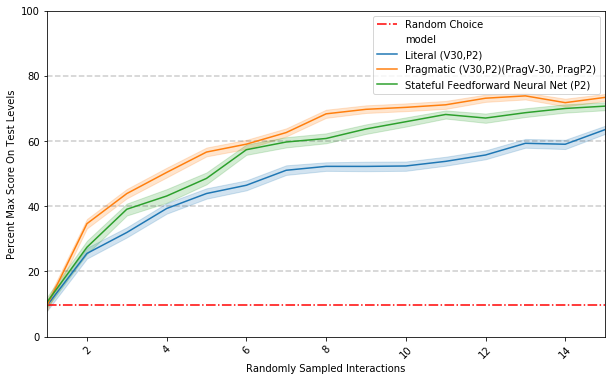

In [9]:
fold_results_df_list = []
for split in range(0, 10):
    
    input_file_path = TEST_FOLDER_PATH + FULL_CORPUS_OUTPUT_FILE_FORMAT.format(split)
    fold_results_df = pd.read_csv(input_file_path)
    fold_results_df["split"] = split
    fold_results_df_list.append(fold_results_df)

baseline_fold_results = pd.concat(fold_results_df_list)

baseline_fold_results["pct_max_100"] = baseline_fold_results.pct_max * 100
baseline_fold_results["iteration_from_1"] = baseline_fold_results.iteration + 1


plt.figure(figsize=(10, 6))
for y in [20, 40, 60, 80]:
    plt.axhline(y, c='k', alpha=.2, linestyle='--')
plt.axhline(9.61, color='r', label="Random Choice", linestyle='-.')

sns.lineplot(data=baseline_fold_results, x="iteration_from_1", y="pct_max_100", hue="model")
plt.ylabel("Percent Max Score On Test Levels")  
plt.xlabel("Randomly Sampled Interactions")
plt.legend(loc="best")
plt.xticks(rotation=45);
plt.ylim(0, 100)
plt.xlim(1, n_steps_per_run);

## Results for Paper: Mean Score over First 10 Interactions

In [10]:
print("Baseline for first 10 levels:")
baseline_fold_results[baseline_fold_results.iteration < 10].groupby(["model"])["pct_max_100"].agg([np.mean, mean_confidence_interval])

Baseline for first 10 levels:


,mean,mean_confidence_interval
model,,
"Literal (V30,P2)",40.455041,0.495747
"Pragmatic (V30,P2)(PragV-30, PragP2)",52.514637,0.467453
Stateful Feedforward Neural Net (P2),47.621214,0.561113


In [11]:
print("Baseline on 10th level:")
baseline_fold_results[baseline_fold_results.iteration == 9].groupby(["model"])["pct_max_100"].agg([np.mean, mean_confidence_interval])

Baseline on 10th level:


,mean,mean_confidence_interval
model,,
"Literal (V30,P2)",52.344125,1.466128
"Pragmatic (V30,P2)(PragV-30, PragP2)",70.320770,1.213954
Stateful Feedforward Neural Net (P2),65.915272,1.388317


## Configure Phrase-Type Analysis Runs

In [12]:
from science.observations.text_analysis import limited_punc_tokenization, classify_phrase_reference_type

def contains_phrase_type(chat, phrase_type):
    
    if chat is None:
        return False
    phrases = limited_punc_tokenization(chat)
    classifications = [classify_phrase_reference_type(p) for p in phrases]
    return any(c == phrase_type for c in classifications)

def filter_chat_for_phrase_type(chat, phrase_type):
    
    if chat is None:
        return None
    phrases = limited_punc_tokenization(chat)
    phrases_of_type = [p for p in phrases if classify_phrase_reference_type(p) == phrase_type]
    if not phrases_of_type:
        return None
    else:
        return " , ".join([p for p in phrases_of_type])

In [13]:
human_experiment_games["feature"] = human_experiment_games.chat_text.apply(lambda x: contains_phrase_type(x, "feature"))
human_experiment_games["trajectory"] = human_experiment_games.chat_text.apply(lambda x: contains_phrase_type(x, "trajectory"))
human_experiment_games["action"] = human_experiment_games.chat_text.apply(lambda x: contains_phrase_type(x, "action_spatial"))

human_experiment_games["feature_components_only"] = human_experiment_games.chat_text.apply(lambda x: filter_chat_for_phrase_type(x, "feature"))
human_experiment_games["trajectory_components_only"] = human_experiment_games.chat_text.apply(lambda x: filter_chat_for_phrase_type(x, "trajectory"))
human_experiment_games["action_components_only"] = human_experiment_games.chat_text.apply(lambda x: filter_chat_for_phrase_type(x, "action_spatial"))

In [14]:
n_testing_runs = 5
n_steps_per_run = 15

PHRASE_OUTPUT_FILE_FORMAT = "aaai_{}_benchmark_split_{}.csv"

for phrase_type in ["trajectory", "feature"]:
    benchmark_games = copy.deepcopy(human_experiment_games[human_experiment_games[phrase_type]])
    benchmark_games["chat_text"] = benchmark_games["{}_components_only".format(phrase_type)]

    for nn_cv_fold_to_use in range(0, 10):

        output_file_path = TEST_FOLDER_PATH + PHRASE_OUTPUT_FILE_FORMAT.format(phrase_type, nn_cv_fold_to_use)

        try:
            open(output_file_path, 'r')
            print("Found phrase \"{}\", fold {} complete run.".format(phrase_type, nn_cv_fold_to_use))

        except:
            print("Did not find phrase \"{}\", fold {}. Running analysis now.".format(phrase_type, nn_cv_fold_to_use))

            fold_models = copy.deepcopy(candidate_models)
            fold_models.append(StatefulFeedforwardNeuralAgent(fold=nn_cv_fold_to_use, name="Inference Network", precision=2))

            cv_fold_rewards = CV_FOLD_DATA[nn_cv_fold_to_use]['test_rewards']
            cv_fold_teachers = CV_FOLD_DATA[nn_cv_fold_to_use]['test_teachers']
            games_to_use = benchmark_games[benchmark_games.task_uuid.isin(cv_fold_teachers)]

            RANDOM_SEEDS = list(range(0, n_testing_runs))
            results = []
            for i in RANDOM_SEEDS:
                random.seed(i)    
                print("Starting run {}/{} ({} models, {} steps per run)".format(i+1, n_testing_runs, len(candidate_models), n_steps_per_run))

                # Get a sample of games
                trial_games_to_train_on = games_to_use.sample(n_steps_per_run, random_state=i)

                # Get a reward function to use
                trial_reward_key = random.sample(cv_fold_rewards, k=1)[0]
                trial_reward_config = reward_config_list[trial_reward_key]
                trial_reward_config_string = "{}|{}".format(trial_reward_config["color_config"], trial_reward_config["shape_config"])
                reward_configured_benchmark_levels = benchmark_levels_by_config_key[trial_reward_config_string]

                results.append(run_models_on_human_human_data(fold_models, 
                                                          trial_games_to_train_on, 
                                                          reward_configured_benchmark_levels,
                                                          trial_reward_config))

            results_dataframe = pd.concat(results)
            results_dataframe.to_csv(output_file_path)

Found phrase "trajectory", fold 0 complete run.
Found phrase "trajectory", fold 1 complete run.
Found phrase "trajectory", fold 2 complete run.
Found phrase "trajectory", fold 3 complete run.
Found phrase "trajectory", fold 4 complete run.
Found phrase "trajectory", fold 5 complete run.
Found phrase "trajectory", fold 6 complete run.
Found phrase "trajectory", fold 7 complete run.
Found phrase "trajectory", fold 8 complete run.
Found phrase "trajectory", fold 9 complete run.
Found phrase "feature", fold 0 complete run.
Found phrase "feature", fold 1 complete run.
Found phrase "feature", fold 2 complete run.
Found phrase "feature", fold 3 complete run.
Found phrase "feature", fold 4 complete run.
Found phrase "feature", fold 5 complete run.
Found phrase "feature", fold 6 complete run.
Found phrase "feature", fold 7 complete run.
Found phrase "feature", fold 8 complete run.
Found phrase "feature", fold 9 complete run.


## Action Phrases

Code takes a slightly different form because (1) the learned model can't do action phrases, and (2) there are relatively few action phrases in the corpus.

In [15]:
n_testing_runs = 5
n_steps_per_run = 15

benchmark_games = copy.deepcopy(human_experiment_games[human_experiment_games["action"]])
benchmark_games["chat_text"] = benchmark_games["action_components_only"]

output_file_name = PHRASE_OUTPUT_FILE_FORMAT.format("action", 0)

# Value configuration doesn't matter, because all of our hand-written models are definitionally agnostic to it.
trial_reward_key = CV_FOLD_DATA[nn_cv_fold_to_use]['test_rewards'][0]
games_to_use = benchmark_games

try:
    open(TEST_FOLDER_PATH + output_file_name, 'r')
    print("Found action phrase complete run.")

except:
    print("Did not find action phrase. Running analysis now.")
            
    RANDOM_SEEDS = list(range(0, n_testing_runs))
    results = []
    for i in RANDOM_SEEDS:
        random.seed(i)    
        print("Starting run {}/{} ({} models, {} steps per run)".format(i+1, n_testing_runs, len(candidate_models), n_steps_per_run))

        # Get a sample of games
        trial_games_to_train_on = games_to_use.sample(n_steps_per_run, random_state=i)

        # Get a reward function to use
        trial_reward_config = reward_config_list[trial_reward_key]
        trial_reward_config_string = "{}|{}".format(trial_reward_config["color_config"], trial_reward_config["shape_config"])
        reward_configured_benchmark_levels = benchmark_levels_by_config_key[trial_reward_config_string]

        results.append(run_models_on_human_human_data(candidate_models, 
                                                  trial_games_to_train_on, 
                                                  reward_configured_benchmark_levels,
                                                  trial_reward_config))

    results_dataframe = pd.concat(results)
    results_dataframe.to_csv(TEST_FOLDER_PATH + output_file_name)

Found action phrase complete run.


In [16]:
phrase_fold_list = []
test_teachers_for_plot = []

phrases = ["feature", "trajectory", "action"]

for phrase in phrases:
    for split in range(0, 10):
    
        try:
            fold_results_df = pd.read_csv(TEST_FOLDER_PATH + PHRASE_OUTPUT_FILE_FORMAT.format(phrase, split))
            fold_results_df["split"] = split
            fold_results_df["Feedback Type"] = phrase
            phrase_fold_list.append(fold_results_df)
            
        except:
            pass
        
phrase_fold_results_df = pd.concat(phrase_fold_list)

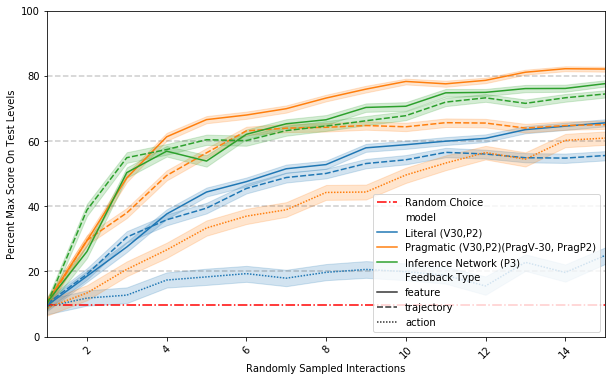

In [17]:
phrase_fold_results_df["pct_max_100"] = phrase_fold_results_df.pct_max * 100
phrase_fold_results_df["iteration_from_1"] = phrase_fold_results_df.iteration + 1

plt.figure(figsize=(10, 6))

for y in [20, 40, 60, 80]:
    plt.axhline(y, c='k', alpha=.2, linestyle='--')
plt.axhline(9.61, color='r', label="Random Choice", linestyle='-.')


sns.lineplot(data=phrase_fold_results_df, x="iteration_from_1", y="pct_max_100", hue="model", style="Feedback Type")
plt.ylabel("Percent Max Score On Test Levels")  
plt.xlabel("Randomly Sampled Interactions")
plt.legend(loc="best")
plt.xticks(rotation=45);
plt.ylim(0, 100)
plt.xlim(1, n_steps_per_run);

In [18]:
phrase_fold_results_df[phrase_fold_results_df.iteration == 10].groupby(["model", "Feedback Type"])["pct_max_100"].agg([np.mean, mean_confidence_interval])

mean  \
model                                Feedback Type              
Inference Network (P3)               feature        74.774820   
                                     trajectory     71.930214   
Literal (V30,P2)                     action         18.836595   
                                     feature        59.943206   
                                     trajectory     56.523661   
Pragmatic (V30,P2)(PragV-30, PragP2) action         53.242416   
                                     feature        77.535968   
                                     trajectory     65.621725   

                                                    mean_confidence_interval  
model                                Feedback Type                            
Inference Network (P3)               feature                        1.156105  
                                     trajectory                     1.233175  
Literal (V30,P2)                     action                         2.558461  
                                     feature                        1.189228  
                                     trajectory                     1.424633  
Pragmatic (V30,P2)(PragV-30, PragP2) action                         2.148533  
                                     feature                        0.898909  
                                     trajectory                     1.305036

## Results for Paper: Mean Score over First 10 Interactions

In [19]:
phrase_fold_results_df[phrase_fold_results_df.iteration < 10].groupby(["model", "Feedback Type"])["pct_max_100"].agg([np.mean, mean_confidence_interval])

mean  \
model                                Feedback Type              
Inference Network (P3)               feature        53.249968   
                                     trajectory     54.340043   
Literal (V30,P2)                     action         16.709780   
                                     feature        40.623351   
                                     trajectory     38.674758   
Pragmatic (V30,P2)(PragV-30, PragP2) action         31.692249   
                                     feature        58.187760   
                                     trajectory     50.377194   

                                                    mean_confidence_interval  
model                                Feedback Type                            
Inference Network (P3)               feature                        0.527284  
                                     trajectory                     0.530445  
Literal (V30,P2)                     action                         0.774843  
                                     feature                        0.475364  
                                     trajectory                     0.515206  
Pragmatic (V30,P2)(PragV-30, PragP2) action                         0.743124  
                                     feature                        0.429842  
                                     trajectory                     0.474776

In [20]:
phrase_fold_results_df[phrase_fold_results_df.iteration < 10].groupby(["model", "Feedback Type"])["pct_max_100"].agg([np.mean, mean_confidence_interval])

mean  \
model                                Feedback Type              
Inference Network (P3)               feature        53.249968   
                                     trajectory     54.340043   
Literal (V30,P2)                     action         16.709780   
                                     feature        40.623351   
                                     trajectory     38.674758   
Pragmatic (V30,P2)(PragV-30, PragP2) action         31.692249   
                                     feature        58.187760   
                                     trajectory     50.377194   

                                                    mean_confidence_interval  
model                                Feedback Type                            
Inference Network (P3)               feature                        0.527284  
                                     trajectory                     0.530445  
Literal (V30,P2)                     action                         0.774843  
                                     feature                        0.475364  
                                     trajectory                     0.515206  
Pragmatic (V30,P2)(PragV-30, PragP2) action                         0.743124  
                                     feature                        0.429842  
                                     trajectory                     0.474776

# Benchmarking Neural Nets

### Random Chance Baseline
```
list_of_levels = list(benchmark_levels_by_config_key.values())[0]
reward_list = []
for i in range(0, 100):
    avg_reward = np.mean([l.possible_actions.sample(1).iloc[0]["reward"]/l.max_reward for l in list_of_levels])
    reward_list.append(avg_reward)
    
100 * np.mean(reward_list)
```

```9.611697789254894```

# Dyad Benchmarks

In [21]:
from science.analysis.model_benchmarking import run_experiment_dyads

DYAD_FILE_NAME = "dyads_analysis.csv"
dyad_results = []

try:
    dyad_results_df = pd.read_csv(TEST_FOLDER_PATH + DYAD_FILE_NAME)

except:

    for nn_cv_fold_to_use in range(0, 10):

        fold_models = [StatefulFeedforwardNeuralAgent(fold=nn_cv_fold_to_use, name="Inference Network", precision=2)]

        cv_fold_data = CV_FOLD_DATA[nn_cv_fold_to_use]
        cv_fold_teachers = cv_fold_data['test_teachers']
        dyad_df = human_experiment_games[human_experiment_games.task_uuid.isin(cv_fold_teachers)]

        configs_to_use = cv_fold_data["test_rewards"]
        random.seed(nn_cv_fold_to_use)
        trial_reward_key = random.sample(configs_to_use, k=1)[0]
        print("Using reward key {}".format(trial_reward_key))

        trial_reward_config = reward_config_list[trial_reward_key]

        fold_results = run_experiment_dyads(fold_models, dyad_df, value_mask_config=trial_reward_config, n=25) 
        dyad_results.append(fold_results)

        candidate_results = run_experiment_dyads(candidate_models, dyad_df, value_mask_config=trial_reward_config, n=25) 
        dyad_results.append(candidate_results[candidate_results.model != 'human'])

    # Finally, go back and get the teachers that weren't included in the NN training / test due downsampling positives
    random.seed(42)
    fold_to_use_for_non_test_teachers = random.choices(range(0,10), k=1)[0]
    print("Using fold {}".format(fold_to_use_for_non_test_teachers))
    
    cv_fold = CV_FOLD_DATA[fold_to_use_for_non_test_teachers]
    all_nn_trained_teachers = cv_fold["training_teachers"] + cv_fold["test_teachers"] + cv_fold["validation_teachers"]
    dyad_df = human_experiment_games[~human_experiment_games.task_uuid.isin(all_nn_trained_teachers)]

    fold_models = [StatefulFeedforwardNeuralAgent(fold=fold_to_use_for_non_test_teachers, name="Inference Network", precision=2)] 

    configs_to_use = cv_fold["test_rewards"]
    trial_reward_key = random.sample(configs_to_use, k=1)[0]
    trial_reward_config = reward_config_list[trial_reward_key]
    fold_results = run_experiment_dyads(fold_models, dyad_df, value_mask_config=trial_reward_config, n=25) 
    dyad_results.append(fold_results)

    candidate_results = run_experiment_dyads(candidate_models, dyad_df, value_mask_config=trial_reward_config, n=25) 
    dyad_results.append(candidate_results[candidate_results.model != 'human'])

    dyad_results_df = pd.concat(dyad_results)
    dyad_results_df.to_csv(TEST_FOLDER_PATH + DYAD_FILE_NAME)

In [22]:
dyad_results_df = pd.read_csv(TEST_FOLDER_PATH + DYAD_FILE_NAME)

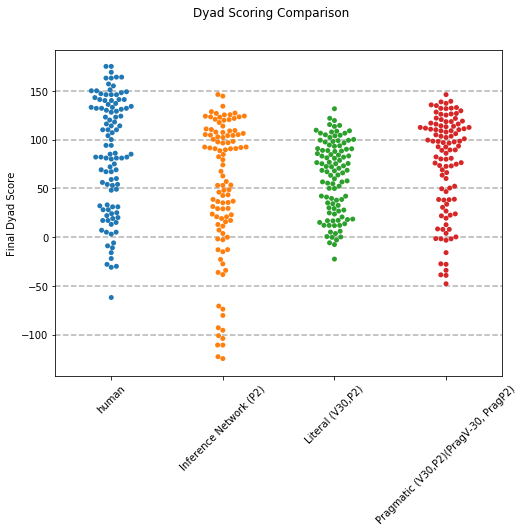

In [23]:
dyad_results_df["running_score"] = dyad_results_df.groupby(["model", "task_uuid"]).reward.cumsum()
final_level_to_plot = dyad_results_df[dyad_results_df.level_number == 10]

plt.figure(figsize=(8, 6))

for y in [-100, -50, 0, 50, 100, 150]:
    plt.axhline(y, c='k', alpha=.3, linestyle='--')

sns.swarmplot(data=final_level_to_plot, x="model", y='running_score',)
 
plt.ylabel("Final Dyad Score")
plt.xlabel("")
plt.suptitle("Dyad Scoring Comparison");
plt.xticks(rotation=45);

In [24]:
from scipy.stats import pearsonr, spearmanr

human_results = final_level_to_plot[final_level_to_plot.model == "human"]

for model in final_level_to_plot.model.unique():
    model_results = final_level_to_plot[final_level_to_plot.model == model]
    print("{}: ".format(model))
    print("\tSpearman: {}".format(spearmanr(human_results.running_score, model_results.running_score)))


human: 
	Spearman: SpearmanrResult(correlation=1.0, pvalue=0.0)
Inference Network (P2): 
	Spearman: SpearmanrResult(correlation=0.659156691833543, pvalue=2.798077292912531e-14)
Literal (V30,P2): 
	Spearman: SpearmanrResult(correlation=0.40874631446037357, pvalue=1.649136557845376e-05)
Pragmatic (V30,P2)(PragV-30, PragP2): 
	Spearman: SpearmanrResult(correlation=0.4894819142349456, pvalue=1.342206322610943e-07)


In [25]:
final_level_to_plot.groupby("model").running_score.agg([np.mean, mean_confidence_interval, np.median, len])

,mean,mean_confidence_interval,median,len
model,,,,
Inference Network (P2),50.601154,13.580291,65.00,104.0
"Literal (V30,P2)",61.594231,7.275066,68.44,104.0
"Pragmatic (V30,P2)(PragV-30, PragP2)",76.249615,9.732304,92.96,104.0
human,85.278846,11.385004,90.00,104.0


# Final Plots

In [26]:
def rename(model_name):
    
    if "Inference Network" in model_name:
        return "Inference Network"
    elif "Feedforward" in model_name:
        return "Inference Network"
    elif "Pragmatic" in model_name:
        return "Pragmatic"
    elif "Literal" in model_name:
        return "Literal"
    elif "human" in model_name:
        return "Humans"

## Random Sampling

In [27]:
fold_results_df_list = []
for split in range(0, 10):
    
    fold_results_df = pd.read_csv(TEST_FOLDER_PATH + FULL_CORPUS_OUTPUT_FILE_FORMAT.format(split))
    fold_results_df["split"] = split
    fold_results_df_list.append(fold_results_df)

baseline_fold_results = pd.concat(fold_results_df_list)

baseline_fold_results["Model"] = baseline_fold_results.model.apply(lambda x: rename(x))

baseline_fold_results["pct_max_100"] = baseline_fold_results.pct_max * 100
baseline_fold_results["iteration_from_1"] = baseline_fold_results.iteration + 1

baseline_fold_results[baseline_fold_results.iteration == 10].groupby(["Model"])["pct_max_100"].agg([np.mean, mean_confidence_interval, np.median])

,mean,mean_confidence_interval,median
Model,,,
Inference Network,68.139656,1.296261,90.000000
Literal,53.765902,1.446234,69.230769
Pragmatic,71.101631,1.168156,89.379699


## Phrase Types

In [28]:
phrase_fold_list = []
test_teachers_for_plot = []

phrases = ["feature", "trajectory", "action"]

for phrase in phrases:
    
    for split in range(0, 10):
        try:
            fold_results_df = pd.read_csv(TEST_FOLDER_PATH + PHRASE_OUTPUT_FILE_FORMAT.format(phrase, split))
            fold_results_df["split"] = split
            fold_results_df["Feedback Type"] = phrase

            phrase_fold_list.append(fold_results_df)
        except:
            pass
        
phrase_fold_results_df = pd.concat(phrase_fold_list)

phrase_fold_results_df["Model"] = phrase_fold_results_df.model.apply(lambda x: rename(x))

phrase_fold_results_df["Feedback Type"] = phrase_fold_results_df["Feedback Type"].str.replace("trajectory", "Evaluative")
phrase_fold_results_df["Feedback Type"] = phrase_fold_results_df["Feedback Type"].str.replace("feature", "Descriptive")
phrase_fold_results_df["Feedback Type"] = phrase_fold_results_df["Feedback Type"].str.replace("action", "Imperative")

phrase_fold_results_df["pct_max_100"] = phrase_fold_results_df.pct_max * 100
phrase_fold_results_df["iteration_from_1"] = phrase_fold_results_df.iteration + 1

phrase_fold_results_df[phrase_fold_results_df.iteration == 10].groupby(["Model", "Feedback Type"])["pct_max_100"].agg([np.mean, mean_confidence_interval, np.median])


mean  mean_confidence_interval  \
Model             Feedback Type                                        
Inference Network Descriptive    74.774820                  1.156105   
                  Evaluative     71.930214                  1.233175   
Literal           Descriptive    59.943206                  1.189228   
                  Evaluative     56.523661                  1.424633   
                  Imperative     18.836595                  2.558461   
Pragmatic         Descriptive    77.535968                  0.898909   
                  Evaluative     65.621725                  1.305036   
                  Imperative     53.242416                  2.148533   

                                    median  
Model             Feedback Type             
Inference Network Descriptive    95.652174  
                  Evaluative     94.736842  
Literal           Descriptive    71.428571  
                  Evaluative     73.684211  
                  Imperative     27.097902  
Pragmatic         Descriptive    94.117647  
                  Evaluative     84.848485  
                  Imperative     73.684211

## Dyads

In [29]:
dyad_results_df = pd.read_csv(TEST_FOLDER_PATH + DYAD_FILE_NAME)

dyad_results_df["running_score"] = dyad_results_df.groupby(["model", "task_uuid"]).reward.cumsum()

final_level_to_plot = dyad_results_df[dyad_results_df.level_number == 10]

final_level_to_plot["Model"]  = final_level_to_plot.model.apply(lambda x: rename(x))

final_level_to_plot.groupby(["Model"]).running_score.agg([np.mean, mean_confidence_interval, np.median])

<ipython-input-29-6ef9c3bb7d0a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_level_to_plot["Model"]  = final_level_to_plot.model.apply(lambda x: rename(x))


,mean,mean_confidence_interval,median
Model,,,
Humans,85.278846,11.385004,90.00
Inference Network,50.601154,13.580291,65.00
Literal,61.594231,7.275066,68.44
Pragmatic,76.249615,9.732304,92.96


In [30]:
from scipy.stats import pearsonr, spearmanr

human_results = final_level_to_plot[final_level_to_plot.model == "human"]

for model in final_level_to_plot.Model.unique():
    model_results = final_level_to_plot[final_level_to_plot.Model == model]
    print("{}: ".format(model))
    print("\tSpearman: {}".format(spearmanr(human_results.running_score, model_results.running_score)))

Humans: 
	Spearman: SpearmanrResult(correlation=1.0, pvalue=0.0)
Inference Network: 
	Spearman: SpearmanrResult(correlation=0.659156691833543, pvalue=2.798077292912531e-14)
Literal: 
	Spearman: SpearmanrResult(correlation=0.40874631446037357, pvalue=1.649136557845376e-05)
Pragmatic: 
	Spearman: SpearmanrResult(correlation=0.4894819142349456, pvalue=1.342206322610943e-07)


## Joint Plot

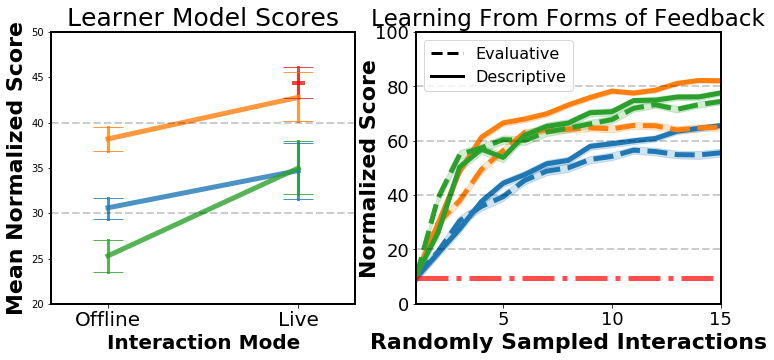

In [31]:
import matplotlib.lines as mlines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

################
joint_results = pd.read_csv("data/regression_input.csv")

plt_linewidth = 5
axis_labelsize = 22
tick_labelsize = 18
title_size = 25
legend_size = 15

to_plot_df = joint_results.copy()

model_sort_order = {'literal': 0, 'pragmatic': 1, 'neural': 2, 'human': 3} 
to_plot_df["secondary_sort"] = to_plot_df.learner_model.apply(lambda x: model_sort_order[x])

to_plot_df = to_plot_df.sort_values(by=['interactive', 'secondary_sort'])

human_mean = to_plot_df[to_plot_df.learner_model == "human"].pct_max_score.mean()


to_plot_df["interactive"] = to_plot_df.interactive.apply(lambda x: "Live" if x else "Offline")
to_plot_df.rename(columns={
    "learner_model": "Model",
    "interactive": "Interaction Mode",
}, inplace=True)

condition_names = {
    "neural": "Inference Network",
    "literal": "Literal",
    "pragmatic": "Pragmatic",
    "human": "Human"
}

plt.rcParams.update({'font.size': 16})

to_plot_df.loc[:,"Model"] = to_plot_df["Model"].apply(lambda x: condition_names.get(x, x))

sns.lineplot(data=to_plot_df, x='Interaction Mode', y='pct_max_score', hue='Model',
                 err_style="bars", err_kws={"capsize": 15, "elinewidth": 3}, ci=68, linewidth=plt_linewidth, alpha=.8, sort=False, ax=ax1)

for y in [20, 30, 40, 50]:
    ax1.axhline(y, c='k', alpha=.2, linestyle='--', linewidth=2)
    
ax1.spines["top"].set_linewidth(2)
ax1.spines["bottom"].set_linewidth(2)
ax1.spines["left"].set_linewidth(2)
ax1.spines["right"].set_linewidth(2)

ax1.axhline(human_mean, xmin=.8, xmax=.829, color='red', label="Humans", alpha=.75, linewidth=4)
ax1.set_ylabel("Mean Normalized Score", fontsize=axis_labelsize, weight='bold')
ax1.set_xlabel("Interaction Mode", fontsize=axis_labelsize-2, weight='bold', )
plt.setp(ax1.get_xticklabels(),fontsize=20)

ax1.get_legend().remove()
ax1.set_ylim(20, 50)

ax1.set_title("Learner Model Scores", size=title_size);
ax1.margins(x=.3)

# Right side

ax2.set_title("Learning From Forms of Feedback", fontsize=title_size - 2);
phrase_results_to_plot = phrase_fold_results_df[phrase_fold_results_df["Feedback Type"] != "Imperative"]
sns.lineplot(ax=ax2, data=phrase_results_to_plot, x="iteration_from_1", y="pct_max_100", hue="Model", style="Feedback Type", 
             hue_order=["Literal", "Pragmatic", "Inference Network"], linewidth=plt_linewidth)

ax2.axhline(9.61, color='r', label="Random Choice", linestyle='-.', alpha=.7, linewidth=plt_linewidth)

for y in [20, 40, 60, 80]:
    ax2.axhline(y, c='k', alpha=.2, linestyle='--', linewidth=2)

ax2.set_ylim(0, 100)
ax2.set_xlim(1, n_steps_per_run)

eval_feedback = mlines.Line2D([], [], color='k', linestyle='--', label='Evaluative', linewidth=3)
desc_feedback = mlines.Line2D([], [], color='k', label='Descriptive',linewidth=3)
ax2.legend(handles=[eval_feedback, desc_feedback], loc=2, prop={'size': 16})

ax2.set_ylabel("Normalized Score", fontsize=axis_labelsize, weight='bold', labelpad=-5)  
ax2.set_xlabel("Randomly Sampled Interactions", fontsize=axis_labelsize, weight='bold')
ax2.tick_params(axis='x', labelsize=tick_labelsize)
ax2.tick_params(axis='y', labelsize=tick_labelsize)

ax2.spines["top"].set_linewidth(2)
ax2.spines["bottom"].set_linewidth(2)
ax2.spines["left"].set_linewidth(2)
ax2.spines["right"].set_linewidth(2)
